# Persian Convolutional Kernels & Heatmap

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 64

In [3]:

import tarfile
tar = tarfile.open("data/SplitData7Tar.tgz")
tar.extractall()
tar.close()

import pathlib
path = Path("SplitData7")

## Data augmentation

In [4]:
tfms = get_transforms(do_flip=False)

In [5]:
doc(get_transforms)

In [6]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [7]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_folder()
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [8]:
data = get_data(224, bs, 'zeros')

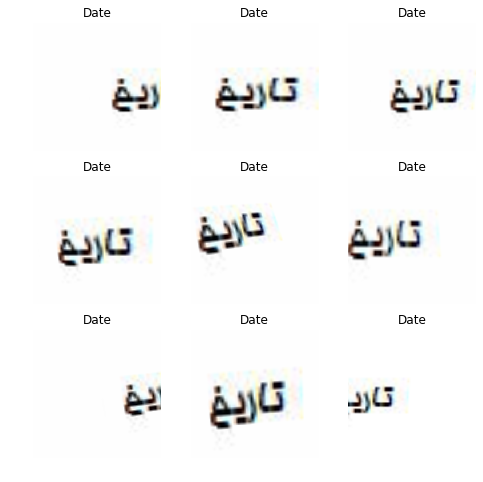

In [99]:
def _plot(i,j,ax):
    x,y = data.train_ds[8888]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [59]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (16632 items)
[Category test, Category test, Category test, Category test, Category test]...
Path: SplitData7
x: ImageItemList (16632 items)
[Image (3, 50, 90), Image (3, 50, 90), Image (3, 50, 90), Image (3, 50, 90), Image (3, 50, 90)]...
Path: SplitData7;

Valid: LabelList
y: CategoryList (4158 items)
[Category 6, Category 6, Category 6, Category Otherchar, Category 0]...
Path: SplitData7
x: ImageItemList (4158 items)
[Image (3, 50, 90), Image (3, 50, 90), Image (3, 50, 90), Image (3, 50, 90), Image (3, 50, 90)]...
Path: SplitData7;

Test: None

In [60]:
data = get_data(224,bs)

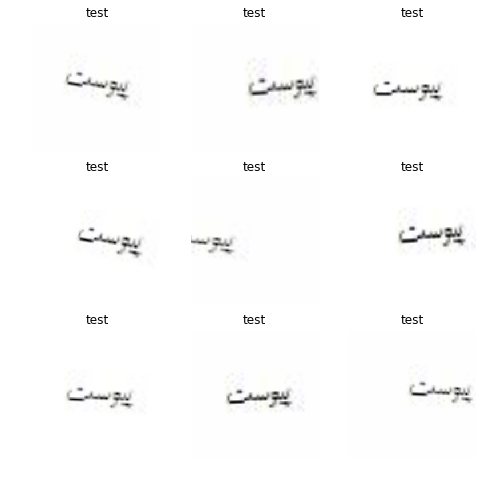

In [61]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [62]:
gc.collect()
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [63]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,1.974069,1.383022,0.325397
2,1.105415,0.861188,0.214286
3,0.844862,0.678317,0.194324


In [64]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.790859,0.644937,0.193362
2,0.755142,0.605667,0.189274


In [65]:
data = get_data(352,bs)
learn.data = data

In [66]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.754411,0.605008,0.188071
2,0.713981,0.602794,0.188552


In [67]:
learn.save('352')

## Convolution kernel

In [68]:
data = get_data(352,16)

In [69]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (16632 items)
[Category test, Category test, Category test, Category test, Category test]...
Path: SplitData7
x: ImageItemList (16632 items)
[Image (3, 50, 90), Image (3, 50, 90), Image (3, 50, 90), Image (3, 50, 90), Image (3, 50, 90)]...
Path: SplitData7;

Valid: LabelList
y: CategoryList (4158 items)
[Category 6, Category 6, Category 6, Category Otherchar, Category 0]...
Path: SplitData7
x: ImageItemList (4158 items)
[Image (3, 50, 90), Image (3, 50, 90), Image (3, 50, 90), Image (3, 50, 90), Image (3, 50, 90)]...
Path: SplitData7;

Test: None

In [70]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Category test

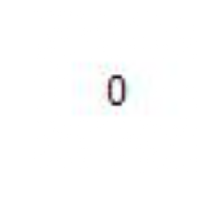

In [101]:
x,y = data.valid_ds[4000]
x.show()
data.valid_ds.y[100]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Category Date

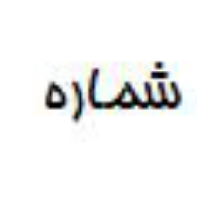

In [102]:
idx=14
x,y = data.valid_ds[400]
x.show()
data.valid_ds.y[idx]

In [103]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [104]:
from fastai.callbacks.hooks import *

In [105]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [106]:
k.shape

torch.Size([1, 3, 3, 3])

In [112]:
t = data.valid_ds[400][0].data; t.shape

torch.Size([3, 352, 352])

In [113]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [114]:
edge = F.conv2d(t[None], k)

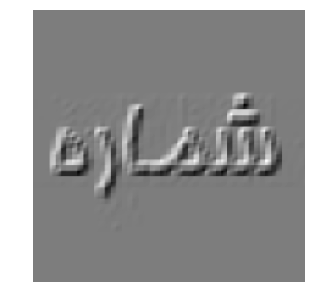

In [115]:
show_image(edge[0], figsize=(5,5));

In [116]:
data.c

19

In [117]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [118]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 64, 176, 176]   9408       False     
______________________________________________________________________
BatchNorm2d          [16, 64, 176, 176]   128        True      
______________________________________________________________________
ReLU                 [16, 64, 176, 176]   0          False     
______________________________________________________________________
MaxPool2d            [16, 64, 88, 88]     0          False     
______________________________________________________________________
Conv2d               [16, 64, 88, 88]     36864      False     
______________________________________________________________________
BatchNorm2d          [16, 64, 88, 88]     128        True      
______________________________________________________________________
ReLU                 [16, 64, 88, 88]     0          False     
______________________________________________________________

## Heatmap

In [119]:
m = learn.model.eval();

In [120]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [121]:
from fastai.callbacks.hooks import *

In [122]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [123]:
hook_a,hook_g = hooked_backward()

In [124]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [125]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [126]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


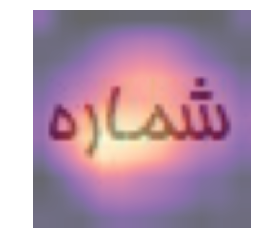

In [127]:
show_heatmap(avg_acts)